# Ejercicios

In [3]:
if (!require("rentrez")) {
    install.packages("rentrez")
}

library(rentrez)
library(httr)
library(ggplot2)
library(xml2)

Loading required package: rentrez

Warning message:
"package 'rentrez' was built under R version 4.1.3"
Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning message:
"package 'xml2' was built under R version 4.1.2"


## Ejercicio 1

Utilice el servicio EInfo de Entrez para construir una tabla que contenga el nombre de la base de datos,
la descripción, el número de registros, y la fecha de la última modificación para todas las bases de datos
disponibles.

In [4]:
dbs <- entrez_dbs()

In [5]:
db_data <- list()
for (db in dbs[1:3]) {
    data <- entrez_db_summary(db)
    elements <- c(
        data["DbName"],
        data["Description"],
        data["Count"],
        data["LastUpdate"]
    )
    db_data[[length(db_data) + 1]] <- elements
}

In [46]:
do.call(rbind, db_data)
#t(sapply(db_data, function(x) x))
# rbind(db_data[[1]], db_data[[2]], db_data[[3]])

rbind(db_data)

print(help("rbind", help_type = "html"))


db_data,"pubmed , PubMed bibliographic record, 33852329 , 2022/03/23 14:36","protein , Protein sequence record, 1030858348 , 2022/03/22 17:04","nuccore , Core Nucleotide db, 491072092 , 2022/03/22 14:59"


Saving help page to 'rbind.pdf'



## Ejercicio 2

Obtenga de la base de datos 'nuccore' de NCBI el número de registros que corresponden con secuencias
del virus HIV-1 que fueron publicadas en cada año desde 1980 hasta 2020. Haga un gráfico de barras para
mostrar estos resultados.

Ayuda: ?barplot

In [48]:
years <- 1980:2020
counter <- c()
for (year in years) {
    Sys.sleep(0.3)
    query <- paste("Human immunodeficiency virus 1[organism] AND", year)
    respuesta <- entrez_search(
        db = "nuccore",
        term = query
    )
    counter <- c(counter, respuesta$count)
}

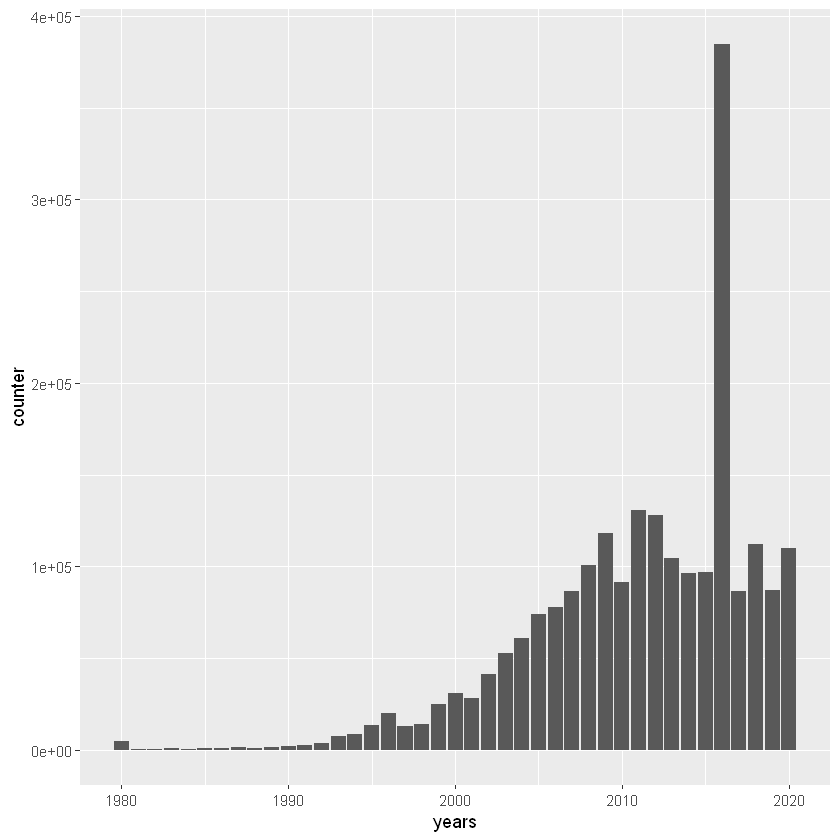

In [49]:
ggplot(
    data = data.frame(counter),
    aes(x = years, y = counter)
) + geom_bar(stat = "identity")

## Ejercicio 3

Buscar información sobre la base de datos MESH (NCBI). ¿Qué información almacena?

- Buscar en esta base de datos el nombre del gen relacionado con la enfermedad Fibrosis Quística (Cystic fibrosis).
  - Ayuda: Buscar campo de búsqueda 'MeSH Terms'.
  - Ayuda: Usar rettype='txt'
  - Ayuda: El nombre del gen aparece en el texto de la descripción.
- Buscar en la base de datos 'gene' de NCBI, los registros de este gen en el ser humano (en formato XML).
- Recuperar la lista de exones. ¿En qué locus está ubicado el gen?.
  - Ayuda: Buscar rettype=gene_table
- Buscar en Swiss-Prot los registros que están asociados a esta proteína.
  - Ayuda: Mapear los ID de genes de NCBI/Entrez a Uniprot.
  - Ayuda: Buscar los tipos de Identificadores correspondientes de la web.
- Recuperar la secuencias de la proteína

In [14]:
query <- "Cystic fibrosis[MeSH Terms]"
respuesta <- entrez_search(
    db = "mesh",
    term = query
)

In [15]:
respuesta2 <- entrez_fetch(
    db = "mesh",
    id = respuesta$ids,
    rettype = "txt"
)

In [16]:
cat(respuesta2)


1: Cystic Fibrosis
An autosomal recessive genetic disease of the EXOCRINE GLANDS. It is caused by
mutations in the gene encoding the CYSTIC FIBROSIS TRANSMEMBRANE CONDUCTANCE
REGULATOR expressed in several organs including the LUNG, the PANCREAS, the
BILIARY SYSTEM, and the SWEAT GLANDS. Cystic fibrosis is characterized by
epithelial secretory dysfunction associated with ductal obstruction resulting in 
AIRWAY OBSTRUCTION; chronic RESPIRATORY INFECTIONS; PANCREATIC INSUFFICIENCY;
maldigestion; salt depletion; and HEAT PROSTRATION.
Year introduced: 1967

Subheadings:
    analysis
    anatomy and histology
    blood
    cerebrospinal fluid
    chemically induced
    chemistry
    classification
    complications
    congenital
    cytology
    diagnosis
    diagnostic imaging
    diet therapy
    drug therapy
    economics
    embryology
    enzymology
    epidemiology
    ethnology
    etiology
    genetics
    history
    immunology
    instrumentation
    isolation and purification
 

In [17]:
query <- "CYSTIC FIBROSIS TRANSMEMBRANE CONDUCTANCE REGULATOR[Title] AND human[orgn]"
respuesta <- entrez_search(
    db = "gene",
    term = query
)


In [18]:
respuesta2 <- entrez_fetch(
    db = "gene",
    id = respuesta$ids[1],
    rettype = "gene_table"
)

In [19]:
cat(respuesta2)

CFTR CF transmembrane conductance regulator[Homo sapiens]
Gene ID: 1080, updated on 20-Mar-2022


Reference GRCh38.p13 Primary Assembly NC_000007.14  from: 117480025 to: 117668665
mRNA  NM_000492.4, 27 exons,  total annotated spliced exon length: 6070
protein  NP_000483.3 (CCDS5773.1), 27 coding  exons,  annotated AA length: 1480

Exon table for  mRNA  NM_000492.4 and protein NP_000483.3
Genomic Interval Exon		Genomic Interval Coding		Gene Interval Exon		Gene Interval Coding		Exon Length	Coding Length	Intron Length
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
117480025-117480147		117480095-117480147		1-123		71-123		123		53		24105
117504253-117504363		117504253-117504363		24229-24339		24229-24339		111		111		4670
117509034-117509142		117509034-117509142		29010-29118		29010-29118		109		109		21756
117530899-117531114		117530899-117531114		50875-51090		50875-5109

In [55]:
retrieve_url <- 'https://www.uniprot.org/uploadlists'
respuesta3 <- GET(
    url = retrieve_url,
    query = list(
        query = respuesta$ids[1],
        format = "tab",
        from = 'P_ENTREZGENEID',
        to = 'ID'
    )
)

In [56]:
respuesta3 <- read.table(
    text = content(respuesta3),
    header = TRUE
)

No encoding supplied: defaulting to UTF-8.



In [58]:
respuesta3

From,To
<int>,<chr>
1080,CFTR_HUMAN
1080,A0A024R730_HUMAN


In [59]:
retrieve_url <- "https://www.uniprot.org/uploadlists"
respuesta4 <- GET(
    url = retrieve_url,
    query = list(
        query = paste(respuesta3$To, collapse = " "),
        format = "fasta",
        from = "ID",
        to = "ACC"
    )
)

In [60]:
cat(content(respuesta4))

>sp|P13569|CFTR_HUMAN Cystic fibrosis transmembrane conductance regulator OS=Homo sapiens OX=9606 GN=CFTR PE=1 SV=3
MQRSPLEKASVVSKLFFSWTRPILRKGYRQRLELSDIYQIPSVDSADNLSEKLEREWDRE
LASKKNPKLINALRRCFFWRFMFYGIFLYLGEVTKAVQPLLLGRIIASYDPDNKEERSIA
IYLGIGLCLLFIVRTLLLHPAIFGLHHIGMQMRIAMFSLIYKKTLKLSSRVLDKISIGQL
VSLLSNNLNKFDEGLALAHFVWIAPLQVALLMGLIWELLQASAFCGLGFLIVLALFQAGL
GRMMMKYRDQRAGKISERLVITSEMIENIQSVKAYCWEEAMEKMIENLRQTELKLTRKAA
YVRYFNSSAFFFSGFFVVFLSVLPYALIKGIILRKIFTTISFCIVLRMAVTRQFPWAVQT
WYDSLGAINKIQDFLQKQEYKTLEYNLTTTEVVMENVTAFWEEGFGELFEKAKQNNNNRK
TSNGDDSLFFSNFSLLGTPVLKDINFKIERGQLLAVAGSTGAGKTSLLMVIMGELEPSEG
KIKHSGRISFCSQFSWIMPGTIKENIIFGVSYDEYRYRSVIKACQLEEDISKFAEKDNIV
LGEGGITLSGGQRARISLARAVYKDADLYLLDSPFGYLDVLTEKEIFESCVCKLMANKTR
ILVTSKMEHLKKADKILILHEGSSYFYGTFSELQNLQPDFSSKLMGCDSFDQFSAERRNS
ILTETLHRFSLEGDAPVSWTETKKQSFKQTGEFGEKRKNSILNPINSIRKFSIVQKTPLQ
MNGIEEDSDEPLERRLSLVPDSEQGEAILPRISVISTGPTLQARRRQSVLNLMTHSVNQG
QNIHRKTTASTRKVSLAPQANLTELDIYSRRLSQETGLEISEEINEEDLKECFFDDMESI
PAVTTWNTYLRYITVHKSLIFVLIWCLVIF

## Ejercicio 4

- Recuperar los registros que corresponden a secuencias nucleotídicas de genomas completos de virus de la familia Flaviviridae. 
- Trabajar con 100.
- Generar un histograma de los tamaños de las secuencias.
- Obtener de cada registro el código del 'TaxID'. Buscar en la base de datos 'Taxonomy' el nombre científico, el rank y la division de cada uno.

- ¿Cuantos corresponde a aislamientos?


In [ ]:
respuesta <- entrez_search(
    db='nuccore',
    term="flaviviridae[orgn] AND complete genome[Title]",
    retmax=10000
)

In [ ]:
respuesta2 <- entrez_summary(
    db='nuccore',
    id=respuesta$ids[1:200],
    rettype='xmls'
)

In [ ]:
flavi <- sapply(
    respuesta2,
    function(x) unlist(x[c('slen', 'taxid', 'organism')])
)
flavi <- as.data.frame(t(flavi))
head(flavi)

In [ ]:
hist(as.numeric(flavi$slen), 20)

In [ ]:
flavi_tax <- entrez_summary(
    db='taxonomy',
    id=flavi$taxid
)

In [ ]:
flavi2 <- sapply(
    flavi_tax,
    function(x) unlist(x[c('rank', 'division', 'scientificname')])
)
flavi2 <- as.data.frame(t(flavi2))

In [ ]:
head(flavi2)

## Ejercicio 5

Recuperar todos los registros que corresponden a secuencias de 'Amapari virus' en la base de datos
'nuc_core'. Recuperar de ellos los identificadores de las publicaciones relacionadas. Obtener de 'pubmed'
el título del artículo, los autores.


In [ ]:
respuesta <- entrez_search(
    db='nuccore',
    term='Amapari virus[orgn]',
    retmax=30
)

In [ ]:
respuesta$ids

In [ ]:
resumenes <- entrez_fetch(
    db='nuccore',
    id=respuesta$ids,
    rettype="text",
    retmode="xml"
)

In [ ]:
pubmed_links <- entrez_link(
    id=respuesta$ids,
    dbfrom='nuccore',
    db="pubmed"
)


In [ ]:

pubmed_links$links$nuccore_pubmed

resumenes <- entrez_summary(
    db="pubmed",
    id=pubmed_links$links$nuccore_pubmed
)

In [ ]:
pubmed_data <- sapply(
    resumenes,
    function(x) c(x[[c('title')]], paste(x[[c('authors')]]$name, collapse=", "))
)
pubmed_data <- t(pubmed_data)

In [ ]:
pubmed_data

## Ejercicio 6

Buscar en base de datos 'SRA' (Sequence Read Archive) de NCBI los registros que corresponden a
los proyectos de secuenciación de virus de la familia Baculoviridae (Trabajar con un máximo de 30).
Recuperar de cada ellos el nómbre del organismo secuenciado y su 'TaxId' y el título del proyecto.

In [61]:
respuesta <- entrez_search(
    db = "sra",
    term = "baculoviridae[orgn]",
    retmax = 30
)

In [62]:
resumenes <- entrez_fetch(
    db = "sra",
    id = respuesta$ids,
    rettype = "xml"
)

In [63]:
sra_data <- as_list(read_xml(resumenes))

In [64]:
head(t(sapply(
    sra_data$EXPERIMENT_PACKAGE_SET,
    function(x) c(
        x$EXPERIMENT$"TITLE",
        x$SAMPLE$"SAMPLE_NAME"$"TAXON_ID",
        x$SAMPLE$"SAMPLE_NAME"$"SCIENTIFIC_NAME"
    )
)))

EXPERIMENT_PACKAGE,Isolation of BmNPV VKK-3 strain from Bombyx mori,271108,Bombyx mori nucleopolyhedrovirus
EXPERIMENT_PACKAGE,Bombyx Mori Nucleopolyhedrovirus sequence collected from South Indian region,271108,Bombyx mori nucleopolyhedrovirus
EXPERIMENT_PACKAGE,Whole genome sequencing of experimentally evolved virus,307456,Autographa californica multiple nucleopolyhedrovirus
EXPERIMENT_PACKAGE,Whole genome sequencing of experimentally evolved virus,307456,Autographa californica multiple nucleopolyhedrovirus
EXPERIMENT_PACKAGE,Whole genome sequencing of experimentally evolved virus,307456,Autographa californica multiple nucleopolyhedrovirus
EXPERIMENT_PACKAGE,Whole genome sequencing of experimentally evolved virus,307456,Autographa californica multiple nucleopolyhedrovirus


## Ejercicio 7

Recuperar todas las secuencias de RefSeq de los virus de la familia
"Coronaviridae". Puede buscar las secuencias RefSeq en el KeyWord.

1. Generar una tabla que tenga el nombre del virus, la cepa, el número de acceso
   y la versión, y el tamaño del genoma (usando ESummary)
2. Hacer un gráfico para mostrar las fechas originales de la secuencia.
3. Recuparar los nombres de los hospedadores de cada virus y agregalor a la
   tabla del punto 1 (Usando EFETCH). Exportar la tabla como un archivo de
   texto (p.e. CSV)

In [42]:
#  srcdb_refseq[PROP]
response <- entrez_search(
    db = "nuccore",
    term = paste(
        "coronaviridae[orgn] AND",
        "complete genome[Title] AND",
        "srcdb_refseq[PROP]"
    ),
    retmax = 10000
)


In [43]:
all_summaries <- entrez_summary(
    db = "nuccore",
    id = response$ids
)

In [44]:
corona_data <- t(sapply(
    all_summaries,
    function(x) unlist(x[c("organism", "strain", "accessionversion", "slen")])
))

In [45]:
head(corona_data)

,organism,strain,accessionversion,slen
1842094220,Duck coronavirus,,NC_048214.1,27754
1830345784,Canada goose coronavirus,Cambridge_Bay_2017,NC_046965.1,28539
1830345777,Alphacoronavirus Bat-CoV/P.kuhlii/Italy/3398-19/2015,Bat-CoV/P.kuhlii/Italy/3398-19/2015,NC_046964.1,28128
1132370269,Lucheng Rn rat coronavirus,,NC_032730.1,28763
1035950675,Ferret coronavirus,,NC_030292.1,28434
409188582,Rousettus bat coronavirus HKU10,,NC_018871.1,28494


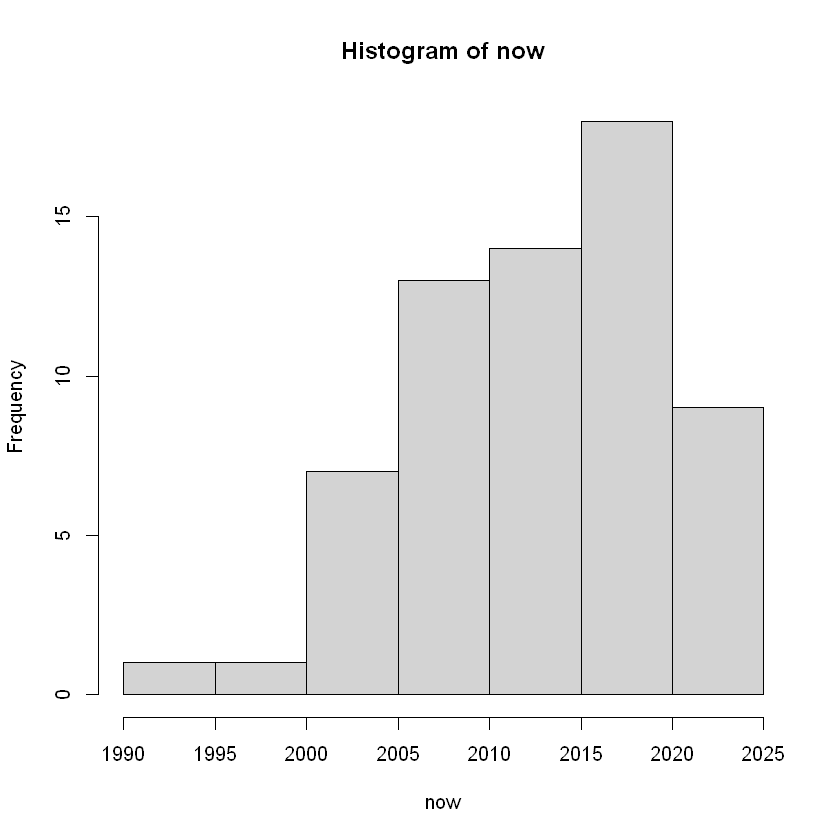

In [46]:
x <- sapply(
    all_summaries,
    function(x) unlist(x[c("createdate")])
)
now <- as.numeric(
    as.POSIXct(
        x,
        format = "%Y/%m/%d"
    )
) / (365 * 24 * 60 * 60) + 1970

hist(now)

In [47]:
full_results <- entrez_fetch(
    db = "nuccore",
    id = response$ids,
    rettype = "native",
    retmode = "xml"
)

In [48]:
fr_doc <- xml2::read_xml(full_results)
fr <- as_list(fr_doc)

In [49]:
length(xml_find_all(fr_doc, "/Bioseq-set/Bioseq-set_seq-set/Seq-entry"))

[1] 63

In [50]:
hosts <- sapply(
    xml_find_all(fr_doc, "/Bioseq-set/Bioseq-set_seq-set/Seq-entry"),
    function(orgnamemod) {
        c_node <- xml_find_first(orgnamemod, ".//OrgName/OrgName_mod")
        if (length(c_node) == 0) {
            return("")
        }
        subname <- ""
        for (i in seq(xml_length(c_node))) {
            child <- xml_child(c_node, i)
            subtype <- xml_find_first(child, ".//OrgMod_subtype")
            if (xml_attr(subtype, "value") == "nat-host") {
                subname <- xml_find_first(child, ".//OrgMod_subname")
                subname <- xml_text(subname)
            }
        }
        return(subname)
    }
)


## Ejercicio 8

La familia Macin (PF14865) son proteínas antibacteriales. El primer miembro de
esta familia fue descripto en el organismo *Hirudo medicinalis* (La sanguijuela
que sea utilizaba en "medicina alternativa").

1. Recuperar de pfam el alineamiento completo para la familia Macin (PF14865).
2. Recuparar las secuencias completas de cada una de las proteinas de Uniprot.
3. Para cada una de las proteínas completas, buscar en pfam todos los dominios
   que contienen.
4. Hacer un gráfico de barras para mostrar la posición de los dominios por
   proteína.

In [56]:
url <- "http://pfam.xfam.org/family"

family_acc <- "PF14865"
respuesta <- GET(url, query=list(output="xml", acc=family_acc))
data <- as_list(content(respuesta))

In [63]:
url <- paste0("https://pfam.xfam.org/family/", family_acc, "/alignment/full")
seed_msa <- GET(url)

In [65]:
text_stockholm <- content(seed_msa, as = "text")

In [84]:
msa <- strsplit(content(seed_msa, as = "text"), "\n")[[1]]

msa <- msa[!startsWith(msa, "#")]
msa <- msa[!startsWith(msa, "//")]
msa <- sapply(
    strsplit(msa, " +"),
    function(x) x[1]
)
msa <- strsplit(msa, "[/-]")
msa

[[1]]
[1] "A0A0B1TKJ8_OESDE" "22"               "77"              

[[2]]
[1] "T1FTM1_HELRO" "26"           "85"          

[[3]]
[1] "T1G674_HELRO" "1"            "54"          

[[4]]
[1] "A0A368GSK2_ANCCA" "21"               "76"              

[[5]]
[1] "T1G475_HELRO" "26"           "86"          

[[6]]
[1] "A0A6J8BLD1_MYTCO" "108"              "163"             

[[7]]
[1] "A0A1D2M6T7_ORCCI" "30"               "84"              

[[8]]
[1] "T1FTL9_HELRO" "28"           "87"          

[[9]]
[1] "A0A368GFY9_ANCCA" "21"               "76"              

[[10]]
[1] "A0A162D6G3_9CRUS" "31"               "63"              

[[11]]
[1] "A0A553NCM8_TIGCA" "30"               "86"              

[[12]]
[1] "A0A0B1T8L5_OESDE" "20"               "79"              

[[13]]
[1] "A0A3S0ZL16_ELYCH" "30"               "86"              

[[14]]
[1] "A0A368GSK2_ANCCA" "161"              "216"             

[[15]]
[1] "A0A0B1TAN9_OESDE" "20"               "75"              

[[16]]
[1] "A0A016UZT5_9BILA" "21"               "76"              

[[17]]
[1] "A0A4X3P5A5_PRIPA" "26"               "81"              

[[18]]
[1] "A0A0B1T8L5_OESDE" "96"               "151"             

[[19]]
[1] "A0A0B1SH62_OESDE" "21"               "76"              

[[20]]
[1] "A0A6J8BLD1_MYTCO" "201"              "257"             

[[21]]
[1] "A0A4X3NQC7_PRIPA" "12"               "67"              

[[22]]
[1] "T1FKE8_HELRO" "126"          "187"         

[[23]]
[1] "A0A0B1T0D4_OESDE" "21"               "73"              

[[24]]
[1] "A0A0B1TJP6_OESDE" "21"               "76"              

[[25]]
[1] "A0A0B1S6J4_OESDE" "21"               "76"              

[[26]]
[1] "A0A0C2F5V5_9BILA" "21"               "73"              

[[27]]
[1] "A0A2G9V2D3_TELCI" "21"               "76"              

[[28]]
[1] "W2TR64_NECAM" "21"           "76"          

[[29]]
[1] "A0A016WYC0_9BILA" "25"               "77"              

[[30]]
[1] "A0A0B1TEV8_OESDE" "21"               "75"              

[[31]]
[1] "A0A016UZ77_9BILA" "21"               "73"              

[[32]]
[1] "A0A226CXP5_FOLCA" "27"               "82"              

[[33]]
[1] "A0A368GSD8_ANCCA" "21"               "76"              

[[34]]
[1] "E9GA98_DAPPU" "29"           "88"          

[[35]]
[1] "T1FN45_HELRO" "25"           "84"          

[[36]]
[1] "T1G467_HELRO" "1"            "56"          

[[37]]
[1] "A0A016SF45_9BILA" "21"               "76"